In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from collections import deque

# Check for CUDA
USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor

# Define the DQN architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent for managing memory and training the network
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99  # Discount factor for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        Q_targets_next = self.target_model(next_states).detach().max(1)[0]
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main training loop
def train_dqn(ues, cells, episodes=1000, batch_size=32):
    env = Environment(ues, cells)
    state_size = len(env.get_state())
    action_size = len(ues) * len(cells)
    agent = DQNAgent(state_size, action_size)
    episodic_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.act(state)
            ue_id = action // len(cells)
            cell_id = action % len(cells)
            next_state, reward, done, info = env.step((ue_id, cell_id))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        print(f'Episode {e+1}/{episodes}: Total reward = {total_reward}')
        episodic_rewards.append(total_reward)
    return agent, episodic_rewards


In [9]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from collections import deque

# Check for CUDA
USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor

# Define the DQN architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent for managing memory and training the network
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99  # Discount factor for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        Q_targets_next = self.target_model(next_states).detach().max(1)[0]
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main training loop
def train_dqn(ues, cells, episodes=1000, batch_size=32):
    env = Environment(ues, cells)
    state_size = len(env.get_state())
    action_size = len(ues) * len(cells)
    agent = DQNAgent(state_size, action_size)
    episodic_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.act(state)
            ue_id = action // len(cells)
            cell_id = action % len(cells)
            next_state, reward, done, info = env.step((ue_id, cell_id))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        print(f'Episode {e+1}/{episodes}: Total reward = {total_reward}')
        episodic_rewards.append(total_reward)
    return agent, episodic_rewards


In [10]:
import pandas as pd

def train_dqn(ues, cells, episodes=500, batch_size=32):
    env = Environment(ues, cells)
    state_size = len(env.get_state())
    action_size = len(ues) * len(cells)
    agent = DQNAgent(state_size, action_size)
    episodicRewards = []
    for e in range(episodes):
        rewards = []
        env.reset()
        state = env.get_state()
        for time in range(len(ues)):
            action = agent.act(state)
            ue_id = action // len(cells)
            cell_id = action % len(cells)
            next_state, reward, done, info = env.step((ue_id, cell_id))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            rewards.append(reward)
            if done:
                print(f"Episode {e}/{episodes}, unmanaged UEs: {env.get_unmanaged()}, rewards: {np.array(rewards).mean()}")
                # break
            if (time % 50 == 0):
                agent.update_target_model()

            if (len(agent.memory) > action_size * 5):  # update end the end of an episode, less frequently to avoid overfitting
                if (time % 5 == 0):
                    loss = agent.replay(batch_size)
                if agent.epsilon > agent.epsilon_min and (time % 10 == 0):
                    agent.epsilon *= agent.epsilon_decay
                if (time % 100 == 0):
                    print("\t\ttraining {}/{}, loss: {}, epsilon: {}, info: {}".format(time, len(ues), loss, agent.epsilon, info['reward_info']))
        episodicRewards.append(np.sum(rewards))
    return agent, episodicRewards

In [ ]:
from sklearn.preprocessing import MinMaxScaler
yScaler = MinMaxScaler()
# Example usage
# ues and cells should be pandas DataFrames as defined in the problem
ues = pd.read_csv('data/data.csv')
cells = pd.read_csv('data/cells.csv')
# cells = cells.rename(columns={"maxCapacity-Kbps": "totalCapacity"})
agent, eR = train_dqn(ues, cells)



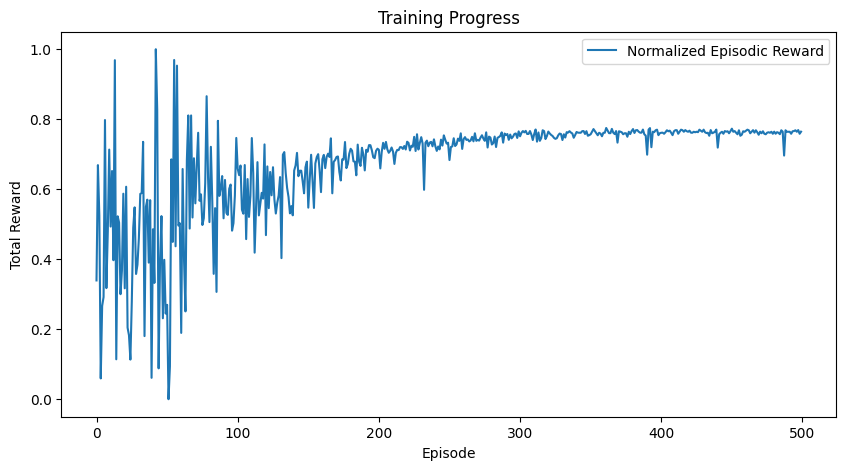

In [22]:
# eR = eR.reshape(-1,1)
eR = np.array(eR)
er = yScaler.fit_transform(eR.reshape(-1,1))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(er, label='Normalized Episodic Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

In [ ]:
def train(num_episodes = 1000, epsilon = 1, epsilon_decay = 0.995, epsilon_min = 0.01, gamma = 0.95, batch_size = 64):
    rewards=[]
    unmanaged_total = []
    for episode in range(num_episodes):
        unmanaged = 0
        reset_cells(cells)  # Reset cells' capacity at the beginning of each episode
        state = get_initial_state(ue, cells)

        for i in range(len(ues)):
            ue = ues.iloc[i]

            action = select_action(state, epsilon)

            allocated_cell = action if cells.at[action, 'currCapacity'] >= ue['throughput(Kbps)'] else None
            # allocated_cell = action if cells.at[action, 'currCapacity'] >= ue['throughput(Kbps)'] else None

            reward, unmanaged = reward_function(ue, allocated_cell, cells, unmanaged)

            next_state = update_state(state, ue, allocated_cell, cells)

            done = i == len(ues) - 1
            store_experience(memory, state, action, reward, next_state, done)

            state = next_state

            if len(memory) > batch_size:
                experiences = sample_experiences(memory, batch_size)
                update_dqn(dqn, optimizer, experiences, gamma)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print(f"Episode {episode + 1}/{num_episodes}, Unmanaged UEs: {unmanaged}, 'Rewarrd: {reward}'")
        rewards.append(reward)
        unmanaged_total.append(unmanaged)

    print("Training completed.")
    return rewards, unmanaged_total

train()

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pandas as pd

# Sample data for UEs and cells
ues = pd.read_csv('data.csv')
cells = pd.read_csv('cells.csv')
cells = cells.rename(columns={"maxCapacity-Kbps": "totalCapacity"})
losses = []

# Define the policy JSON
policy = {
    '1': {
        'p1': 'macro',
        'p2': 'pico',
        'p3': 'anchored'
    },
    '2': {
        'p1': 'macro',
        'p2': 'anchored',
        'p3': 'pico'
    },
    '3': {
        'p1': 'pico',
        'p2': 'anchored',
        'p3': 'macro'
    },
    '4': {
        'p1': 'anchored',
        'p2': 'macro',
        'p3': 'pico'
    }
}

# Define the state dimension (e.g., ue position, throughput, and base station loads)
state_dim = 4 + 2 * len(cells)  # (x, y, throughput, slice) + (current capacity, total capacity for each base station)
action_dim = len(cells)  # Number of base stations

# Define the neural network for DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to select action based on epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = dqn(state)
        return torch.argmax(q_values).item()

# Function to store experience in replay memory
def store_experience(memory, state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Function to sample a batch of experiences from replay memory
def sample_experiences(memory, batch_size):
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Function to update DQN based on a batch of experiences
def update_dqn(dqn, optimizer, experiences, gamma):
    states, actions, rewards, next_states, dones = experiences

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = dqn(next_states).max(1)[0]
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Reward function
def reward_function(ue, allocated_cell, cells, unmanaged):
    reward = 0

    if allocated_cell is not None:
        ue_slice = str(ue['slice'])
        cell = cells.iloc[allocated_cell]
        cellType = ""
        if cell['anchored'] == 1:
            cellType = "anchored"
        elif cell['pico'] == 1:
            cellType = "pico"
        else:
            cellType = "macro"

        preference = policy[ue_slice]
        if cellType == preference['p1']:
            reward += 20
        elif cellType == preference['p2']:
            reward += 10
        elif cellType == preference['p3']:
            reward += 5

        if cell['currCapacity'] < 0:
            reward -= 50
    else:
        reward -= 100
        unmanaged += 1

    total_capacity = sum(cells['totalCapacity'])
    current_load = sum(cells['totalCapacity'] - cells['currCapacity'])
    load_balance = current_load / total_capacity

    if load_balance > 0.95:  # Example threshold for high load
        reward -= 20
    else:
        reward += 10

    return reward, unmanaged

# Initialize DQN, optimizer, and replay memory
dqn = DQN(state_dim, action_dim)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
memory = deque(maxlen=10000)

# Function to get the initial state for a UE
def get_initial_state(ue, cells):
    state = [ue['x'], ue['y'], ue['throughput(Kbps)'], ue['slice']]
    for _, cell in cells.iterrows():
        state.extend([cell['currCapacity'], cell['totalCapacity']])
    return np.array(state)

# Function to update the state after an action
def update_state(state, ue, allocated_cell, cells):
    if allocated_cell is not None:
        cells.at[allocated_cell, 'currCapacity'] -= ue['throughput(Kbps)']
    state = get_initial_state(ue, cells)
    return state

# Reset cells' current capacity
def reset_cells(cells):
    cells['currCapacity'] = cells['totalCapacity']
    ues['allocatedCell'] = 0

# Training loop
num_episodes = 500
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.95
batch_size = 64
rewards = []
unmanaged_total = []
for episode in range(num_episodes):
    unmanaged = 0
    reset_cells(cells)  # Reset cells' capacity at the beginning of each episode

    for i in range(len(ues)):
        ue = ues.iloc[i]
        state = get_initial_state(ue, cells)

        action = select_action(state, epsilon)
        allocated_cell = action if cells.at[action, 'currCapacity'] >= ue['throughput(Kbps)'] else None

        reward, unmanaged = reward_function(ue, allocated_cell, cells, unmanaged)
        next_state = update_state(state, ue, allocated_cell, cells)

        done = i == len(ues) - 1
        store_experience(memory, state, action, reward, next_state, done)

        if len(memory) > batch_size:
            experiences = sample_experiences(memory, batch_size)
            update_dqn(dqn, optimizer, experiences, gamma)

        if allocated_cell is not None:
            ues.at[i, 'allocatedCell'] = allocated_cell

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode + 1}/{num_episodes}, Unmanaged UEs: {unmanaged}, Reward: {reward}")
    rewards.append(reward)
    unmanaged_total.append(unmanaged)

print("Training completed.")


Episode 1/500, Unmanaged UEs: 10, Reward: 15
Episode 2/500, Unmanaged UEs: 12, Reward: 20
Episode 3/500, Unmanaged UEs: 13, Reward: 15
Episode 4/500, Unmanaged UEs: 15, Reward: 20
Episode 5/500, Unmanaged UEs: 7, Reward: 20
Episode 6/500, Unmanaged UEs: 9, Reward: 15
Episode 7/500, Unmanaged UEs: 21, Reward: 15
Episode 8/500, Unmanaged UEs: 9, Reward: 20
Episode 9/500, Unmanaged UEs: 22, Reward: 20
Episode 10/500, Unmanaged UEs: 11, Reward: 20
Episode 11/500, Unmanaged UEs: 18, Reward: 20
Episode 12/500, Unmanaged UEs: 19, Reward: 20
Episode 13/500, Unmanaged UEs: 5, Reward: 20
Episode 14/500, Unmanaged UEs: 12, Reward: 20
Episode 15/500, Unmanaged UEs: 16, Reward: 30
Episode 16/500, Unmanaged UEs: 11, Reward: 30
Episode 17/500, Unmanaged UEs: 15, Reward: 20
Episode 18/500, Unmanaged UEs: 7, Reward: 30
Episode 19/500, Unmanaged UEs: 23, Reward: 20
Episode 20/500, Unmanaged UEs: 11, Reward: 20
Episode 21/500, Unmanaged UEs: 23, Reward: 30
Episode 22/500, Unmanaged UEs: 11, Reward: 30
Ep

In [ ]:
# @title Default title text
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pandas as pd

# Sample data for UEs and cells
ues = pd.read_csv('data.csv')
cells = pd.read_csv('cells.csv')
cells = cells.rename(columns={"maxCapacity-Kbps": "totalCapacity"})
losses = []

# Define the policy JSON
policy = {
    '1': {
        'p1': 'macro',
        'p2': 'pico',
        'p3': 'anchored'
    },
    '2': {
        'p1': 'macro',
        'p2': 'anchored',
        'p3': 'pico'
    },
    '3': {
        'p1': 'pico',
        'p2': 'anchored',
        'p3': 'macro'
    },
    '4': {
        'p1': 'anchored',
        'p2': 'macro',
        'p3': 'pico'
    }
}

# Define the state dimension (e.g., ue position, throughput, and base station loads)
state_dim = 4 + 2 * len(cells)  # (x, y, throughput, slice) + (current capacity, total capacity for each base station)
action_dim = len(cells)  # Number of base stations

# Define the neural network for DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to select action based on epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = dqn(state)
        return torch.argmax(q_values).item()

# Function to store experience in replay memory
def store_experience(memory, state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Function to sample a batch of experiences from replay memory
def sample_experiences(memory, batch_size):
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Function to update DQN based on a batch of experiences
def update_dqn(dqn, optimizer, experiences, gamma):
    states, actions, rewards, next_states, dones = experiences

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = dqn(next_states).max(1)[0]
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def reward_function(ue, allocated_cell, cells, unmanaged):
    reward = 0
    r1 = 0
    r2 = 0
    r3 = 0

    if allocated_cell is not None:
        ue_slice = str(ue['slice'])
        cell = cells.iloc[allocated_cell]
        cellType = ""
        if cell['anchored'] == 1:
            cellType = "anchored"
        elif cell['pico'] == 1:
            cellType = "pico"
        else:
            cellType = "macro"

        preference = policy[ue_slice]
        if cellType == preference['p1']:
            r1 += 20
        elif cellType == preference['p2']:
            r1 += 10
        elif cellType == preference['p3']:
            r1 += 5

        if cell['currCapacity'] < 0:
            r1 -= 100
    else:
        r2 -= 50  # Adjust the penalty for unmanaged users here
        unmanaged += 1

    total_capacity = sum(cells['totalCapacity'])
    current_load = sum(cells['totalCapacity'] - cells['currCapacity'])
    load_balance = current_load / total_capacity

    if load_balance > 0.95:
        r3 -= 20
    elif load_balance < 0.05:
        r3 -= 10
    else:
        r3 += 15

    # Include the unmanaged users in the reward
    # r4 = -unmanaged * 0.8  # Adjust the penalty for unmanaged users here

    reward = r1 + r2 + r3
    return reward, unmanaged


# Initialize DQN, optimizer, and replay memory
dqn = DQN(state_dim, action_dim)
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
memory = deque(maxlen=10000)

# Function to get the initial state for a UE
def get_initial_state(ue, cells):
    state = [ue['x'], ue['y'], ue['throughput(Kbps)'], ue['slice']]
    for _, cell in cells.iterrows():
        state.extend([cell['currCapacity'], cell['totalCapacity']])
    return np.array(state)

# Function to update the state after an action
def update_state(state, ue, allocated_cell, cells):
    if allocated_cell is not None:
        cells.at[allocated_cell, 'currCapacity'] -= ue['throughput(Kbps)']
    state = get_initial_state(ue, cells)
    return state

# Reset cells' current capacity
def reset_cells(cells):
    cells['currCapacity'] = cells['totalCapacity']
    ues['allocatedCell'] = -1  # Initialize with -1 to indicate no allocation

# Training loop
num_episodes = 1000
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.99
batch_size = 64
rewards = []
unmanaged_total = []

for episode in range(num_episodes):
    unmanaged = 0
    reset_cells(cells)  # Reset cells' capacity at the beginning of each episode

    for i in range(len(ues)):
        ue = ues.iloc[i]
        state = get_initial_state(ue, cells)

        action = select_action(state, epsilon)
        allocated_cell = action if cells.at[action, 'currCapacity'] >= ue['throughput(Kbps)'] else None

        reward, unmanaged = reward_function(ue, allocated_cell, cells, unmanaged)
        next_state = update_state(state, ue, allocated_cell, cells)

        done = i == len(ues) - 1
        store_experience(memory, state, action, reward, next_state, done)

        if len(memory) > batch_size:
            experiences = sample_experiences(memory, batch_size)
            update_dqn(dqn, optimizer, experiences, gamma)

        if allocated_cell is not None:
            ues.at[i, 'allocatedCell'] = allocated_cell

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode + 1}/{num_episodes}, Unmanaged UEs: {unmanaged}, Reward: {reward}")
    rewards.append(reward)
    unmanaged_total.append(unmanaged)

print("Training completed.")


Episode 1/1000, Unmanaged UEs: 10, Reward: 17.0
Episode 2/1000, Unmanaged UEs: 12, Reward: 15.399999999999999
Episode 3/1000, Unmanaged UEs: 15, Reward: 8.0
Episode 4/1000, Unmanaged UEs: 10, Reward: 17.0
Episode 5/1000, Unmanaged UEs: 12, Reward: 15.399999999999999
Episode 6/1000, Unmanaged UEs: 10, Reward: 12.0
Episode 7/1000, Unmanaged UEs: 13, Reward: 9.6
Episode 8/1000, Unmanaged UEs: 11, Reward: 26.2
Episode 9/1000, Unmanaged UEs: 7, Reward: 14.399999999999999
Episode 10/1000, Unmanaged UEs: 10, Reward: 17.0
Episode 11/1000, Unmanaged UEs: 22, Reward: 2.3999999999999986
Episode 12/1000, Unmanaged UEs: 9, Reward: 12.8
Episode 13/1000, Unmanaged UEs: 6, Reward: 20.2
Episode 14/1000, Unmanaged UEs: 9, Reward: 17.8
Episode 15/1000, Unmanaged UEs: 14, Reward: 8.799999999999999
Episode 16/1000, Unmanaged UEs: 9, Reward: 17.8
Episode 17/1000, Unmanaged UEs: 6, Reward: 30.2
Episode 18/1000, Unmanaged UEs: 14, Reward: 13.799999999999999
Episode 19/1000, Unmanaged UEs: 13, Reward: 14.6
Epi

In [ ]:
torch.save(dqn.state_dict(), 'dqn_model.pth')

# Load the model
loaded_dqn = DQN(state_dim, action_dim)
loaded_dqn.load_state_dict(torch.load('dqn_model.pth'))
loaded_dqn.eval()


DQN(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
avgLosses=[]
for i in range(0, len(losses), 250):
  sum=0
  for j in range(i, min(i+250, len(losses))):
    sum+=losses[j]
  avgLosses.append(sum/250)

In [ ]:
avgLosses

[113279399.83302344,
 32012.223233398436,
 198720.34135546876,
 41206.81221923828,
 8025.5259140625,
 5193.445758300782,
 3841.679263183594,
 3010.3082963867187,
 2323.375413574219,
 2024.772037109375,
 1990.73519921875,
 2043.0663901367188,
 1911.4184074707032,
 44963.535158569335,
 610.6759399414062,
 602.5243039550782,
 603.0962336425781,
 599.2567807617188,
 593.9852122802735,
 608.9882854003906,
 600.9431893310547,
 605.4627314453126,
 609.114422241211,
 641.5895341796875,
 610.0207698974609,
 602.7572967529297,
 605.8114799804688,
 606.4348239746093,
 601.3409138183594,
 608.91559765625,
 606.5622673339843,
 605.6370028076171,
 606.3602919921875,
 595.1091939697266,
 603.6307806396485,
 604.9861921386719,
 603.5842362060547,
 598.125185546875,
 603.3802864990234,
 601.6311723632813,
 605.0648596191406,
 610.0059719238282,
 605.2898825683594,
 606.1266936035156,
 603.0210792236328,
 599.4928791503906,
 604.6352176513672,
 595.1275181884765,
 598.2363079833984,
 600.7289500732422,


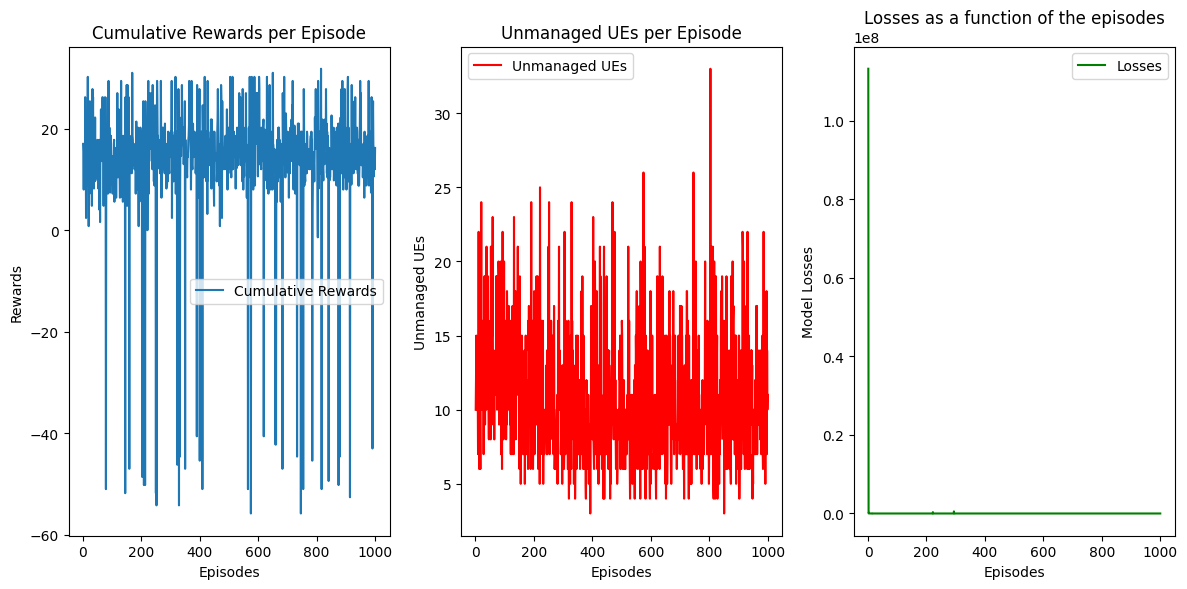

In [ ]:
import matplotlib.pyplot as plt

# Assuming rewards and unmanaged_total are your lists
episodes = range(1, len(rewards) + 1)

plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(1, 3, 1)
plt.plot(episodes, rewards, label='Cumulative Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Cumulative Rewards per Episode')
plt.legend()

# Plot unmanaged UEs
plt.subplot(1, 3, 2)
plt.plot(episodes, unmanaged_total, label='Unmanaged UEs', color='r')
plt.xlabel('Episodes')
plt.ylabel('Unmanaged UEs')
plt.title('Unmanaged UEs per Episode')
plt.legend()


# Plot unmanaged UEs
plt.subplot(1, 3, 3)
plt.plot(episodes, avgLosses, label='Losses', color='green')
plt.xlabel('Episodes')
plt.ylabel('Model Losses')
plt.title('Losses as a function of the episodes')
plt.legend()

plt.tight_layout()
plt.show()


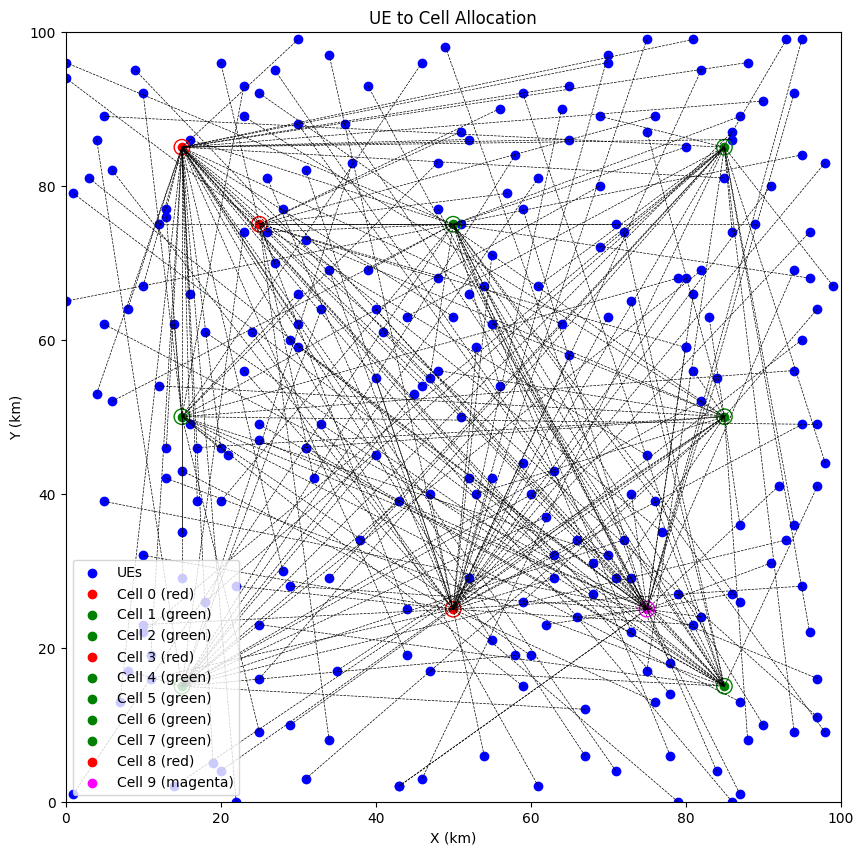

In [ ]:
import matplotlib.pyplot as plt
# Save the model
torch.save(dqn.state_dict(), 'dqn_model.pth')

# Load the model
loaded_dqn = DQN(state_dim, action_dim)
loaded_dqn.load_state_dict(torch.load('dqn_model.pth'))
loaded_dqn.eval()


# allocated_cells = ues['allocatedCell']


# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot UEs
ax.scatter(ues['x'], ues['y'], c='blue', label='UEs')

# Plot Cells with different colors based on their types
for i, cell in cells.iterrows():
    if cell['anchored'] == 1:
        color = 'red'
    elif cell['pico'] == 1:
        color = 'green'
    else:
        color = 'magenta'

    ax.scatter(cell['x'], cell['y'], c=color, label=f'Cell {i} ({color})')
    circle = plt.Circle((cell['x'], cell['y']), 1.0, color=color, fill=False)
    ax.add_artist(circle)

# Plot connections
for i, ue in ues.iterrows():
    cell_idx = ue['allocatedCell']
    cell = cells.iloc[cell_idx]
    ax.plot([ue['x'], cell['x']], [ue['y'], cell['y']], 'k--', lw=0.5)

# Set limits and labels
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('UE to Cell Allocation')

plt.legend()
plt.show()


In [ ]:
import numpy as np
import random
class Environment:
    def __init__(self, ues, cells):
        self.ues = ues
        self.cells = cells
        self.reset()

    def reset(self):
        self.current_step = 0
        self.unmanaged = 0
        self.ues['allocatedCell'] = 0
        self.cells['currCapacity'] = self.cells['maxCapacity-Kbps']

    def step(self, action):
        ue_id, cell_id = action
        ue = self.ues.iloc[ue_id]
        cell = self.cells.iloc[cell_id]

        if cell['currCapacity'] >= ue['throughput(Kbps)']:
            self.cells.loc[cell_id, 'currCapacity'] -= ue['throughput(Kbps)']
            self.ues.loc[ue_id, 'allocatedCell'] = cell_id
            reward = 1  # Managed UE successfully
        else:
            reward = -1  # Overloaded base station

        done = self.current_step >= len(self.ues)
        self.current_step += 1

        return self.get_state(), reward, done

    def get_state(self):
        ue_allocations = self.ues['allocatedCell'].values
        cell_capacities = self.cells['currCapacity'].values
        state = np.concatenate((ue_allocations, cell_capacities))
        return state

    def get_unmanaged(self):
        return (self.ues['allocatedCell'] == 0).sum()



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state).unsqueeze(0)
                target = reward + self.gamma * torch.max(self.target_model(next_state)[0])
            state = torch.FloatTensor(state).unsqueeze(0)
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = F.mse_loss(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)


In [ ]:
import pandas as pd
def train_dqn(ues, cells, episodes=1000, batch_size=64):
    env = Environment(ues, cells)
    state_size = len(env.get_state())
    action_size = len(ues) * len(cells)
    agent = DQNAgent(state_size, action_size)

    for e in range(episodes):
        env.reset()
        state = env.get_state()
        for time in range(len(ues)):
            action = agent.act(state)
            ue_id = action // len(cells)
            cell_id = action % len(cells)
            next_state, reward, done = env.step((ue_id, cell_id))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.update_target_model()
                print(f"Episode {e}/{episodes}, unmanaged UEs: {env.get_unmanaged()}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

    return agent

# Example usage
# ues and cells should be pandas DataFrames as defined in the problem
ues = pd.read_csv('data.csv')
cells = pd.read_csv('cells.csv')
# cells = cells.rename(columns={"maxCapacity-Kbps": "totalCapacity"})
agent = train_dqn(ues, cells)
